## Calculate a distribution for solar events
Use Space Weather Prediction Centre's (SWPC) Solar and Geophysical Event Reports (SGER) to find a distribution for solar events.

This notebook uses parsing code from:  
*Boucheron, Laura E., et al. "Solar active region magnetogram image dataset for studies of space weather." Scientific Data 10.1 (2023): 825.*
Specifically [SRS_Parse.py](https://github.com/DuckDuckPig/AR-flares/blob/master/general_code/SRS_Parse.py) and [customize_dataset.py](https://github.com/DuckDuckPig/AR-flares/blob/master/general_code/customize_dataset.py)

SWPC data is downloaded from: `ftp://ftp.swpc.noaa.gov/pub/warehouse/` and relevant SRS and event files of interest are assumed to be decompressed in one folder, e.g. `SWPC/SRS/<DATE>SRS.txt` and `SWPC/events/<DATE>events.txt`. 

Set maximum lat and lon of areas of interest

In [ ]:
MAX_LAT = 60
MAX_LON = 60

Modified SRS parser to extract dates and locations of events 

In [59]:
# This program loops through the Solar Region Summaries (SRS) to determine dates
# an active region (AR) is visible on disk.  The SRS are assumed to be downloaded
# to the SRS/ subdirectory underneath the specified SRS_directory variable set
# at the beginning of this code.  The SRS are downloaded as one .txt file per
# day.  We used Part I data in the SRS which detail those ARs with associated
# sunspot structure.  For each NOAA AR appearing in SRS Part I, we store the NOAA
# AR number, the date the AR first appears in the SRS, and accumulate the total
# number of days the same AR appears in the SRS.  We store these data in a comma
# separated text file ARList.txt where each line is of the format NNN,YYYMMDD,X,
# where NNNN is the four digit NOAA AR number, YYYYMMDD is the initial date of
# appearance, and X is an integer number of days.
#
#
# References:
# [1] L. E. Boucheron, T. Vincent, J. A. Grajeda, and E. Wuest, "Solar Active
#     Region Magnetogram Image Dataset for Studies of Space Weather," arXiv
#     preprint arXiv:2305.09492, 2023.
#
# Copyright 2022 Ty Vincent, Laura Boucheron
# This file is part of AR-flares
#
# AR-flares is free software: you can redistribute it and/or modify it under
# the terms of the GNU General Public License as published by the Free Software
# Foundation, either version 3 of the License, or (at your option) any later
# version.
#
# AR-flares is distributed in the hope that it will be useful, but WITHOUT ANY
# WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR
# A PARTICULAR PURPOSE. See the GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License along with
# AR-flares. If not, see <https://www.gnu.org/licenses/>.

import os
import glob

## User Definitions
SRS_directory = (
    "/home/walsh/data/SWPC"  # directory underneath which the SRS/ directory resides
)
file_directory = "./"  # directory into which to write ARList.txt
## End User Definitions

SRS_dirs = sorted(glob.glob(SRS_directory + "/SRS/*"))  # list of SRS directories
srsArr = []  # to keep track of ARs

# Loop through the list of folders containing text files
# for SRS_dir in SRS_dirs:
#     SRS_files = sorted(glob.glob(SRS_dir+'/*'))

# Loop through each text file in the folders
lat_lons = {}
for SRS_file in SRS_dirs:
    date = os.path.basename(SRS_file).split("S")[0]  # strip off date string

    if int(date) < 20100909 or int(date) > 20230526:
        pass
    else:
        with open(SRS_file, "r") as f:
            lines = f.readlines()
            for index, line in enumerate(lines):
                if "IA" in line:  # have reached section after I.
                    break
                elif "Nmbr" in line:  # first line of section I.
                    i = 1  # line counter
                    try:
                        while (
                            "IA" not in lines[index + i]
                            and "None" not in lines[index + i]
                        ):  # end of section indicators

                            a = lines[index + i].split(" ")

                            NoaaNum = a[0]  # pull off NOAA number
                            flag = False  # if NOAA number seen before

                            # Extract latitude and longitude
                            lon = a[1]
                            if "W" in lon:
                                # latitude is left of the Lon direction
                                lat = lon.split("W")[0]
                                lon = int(lon.split("W")[1])
                            elif "E" in lon:
                                lat = lon.split("E")[0]
                                lon = -int(lon.split("E")[1])

                            if "N" in lat:
                                lat = int(lat.split("N")[1])
                            elif "S" in lat:
                                lat = -int(lat.split("S")[1])

                            # Inside our region of interest
                            if (abs(int(lon)) < int(MAX_LON)) or (
                                abs(int(lat)) < int(MAX_LAT)
                            ):
                                if NoaaNum not in lat_lons:
                                    lat_lons[NoaaNum] = [(date, lat, lon)]
                                else:
                                    lat_lons[NoaaNum].append((date, lat, lon))

                            for item in srsArr:  # check if NOAA seen yet
                                if item[0] == NoaaNum:
                                    flag = True
                                    ind = srsArr.index(item)

                            if flag == True:  # update for seen NOAA
                                srsArr[ind][2] = srsArr[ind][2] + 1

                            else:  # start for new NOAA
                                srsArr.append([NoaaNum, date, 1])

                            i = i + 1  # increment line counter
                    except IndexError as e:
                        print(SRS_file, e)


fwrite = open(file_directory + "/ARList_20100909_to_20230526.txt", "w+")

for line in srsArr:
    fwrite.write(str(line[0]) + "," + str(line[1]) + "," + str(line[2]) + "\n")

fwrite.close()

/home/walsh/data/SWPC/SRS/20191011SRS.txt list index out of range


Modified from AR-flares to combine seen flare locations with events of XRA (flare) type (or set `ALL_EVENTS` to save all) 

In [144]:
fwrite = open("all_events_list.txt", "w")
event_files = sorted(glob.glob("/home/walsh/data/SWPC/events/*.txt"))
event_flares = {}
# for event_dir in event_dirs:
#     event_files = sorted(glob.glob(event_dir+'/*.txt'))
ALL_EVENTS = True
for event_file in event_files:
    with open(event_file, "r") as f:
        for line in f:
            if ":Date:" in line:
                date = (line.split(":Date: ")[1]).rstrip()
            if "XRA" in line or ALL_EVENTS:
                startTime = line[11:15]
                peakTime = line[18:22]
                endTime = line[28:32]
                noaaNum = line[-5:].rstrip()
                flare = line[58:62].rstrip()
                if noaaNum == "" or date == "" or flare == "":
                    pass
                else:
                    fwrite.write(
                        date + "," + peakTime + "," + noaaNum + "," + flare + "\n"
                    )
                    k = noaaNum  # +'-'+date.replace(' ', '')
                    if noaaNum not in event_flares:
                        event_flares[k] = [
                            (date.replace(" ", ""), startTime, peakTime, endTime, flare)
                        ]
                    else:
                        event_flares[k].append(
                            (date.replace(" ", ""), startTime, peakTime, endTime, flare)
                        )

fwrite.close()

Melt these and save to csv

In [145]:
import pandas as pd

missing_flares = 0
noaa = []
date = []
flare = []
peak = []
start = []
end = []
lat = []
lon = []
for k, v in event_flares.items():
    for f in v:
        # find lat lon for this date
        if k in lat_lons:
            tmp = [x[0] for x in lat_lons[k]]
            idx = None
            if f[0] in tmp:
                idx = tmp.index(f[0])
            f[0] in []
            if k in lat_lons and idx is not None:
                noaa.append(k)
                date.append(f[0])
                start.append(f[1])
                peak.append(f[2])
                end.append(f[3])
                flare.append(f[4])
                lat.append(lat_lons[k][idx][1])
                lon.append(lat_lons[k][idx][2])
        else:
            missing_flares += 1
            # print(f'Location for {k} not found')

print(f"Missing flares: {missing_flares}")
flares = pd.DataFrame(
    {
        "noaa": noaa,
        "date": date,
        "start": start,
        "peak": peak,
        "end": end,
        "flare": flare,
        "lat": lat,
        "lon": lon,
    }
)
flares.to_csv("allevents_list_with_locations.csv", index=False)

Missing flares: 25525


In [147]:
flares.shape

(37813, 8)

Plot locations of ALL FLARES

<Axes: xlabel='lon', ylabel='lat'>

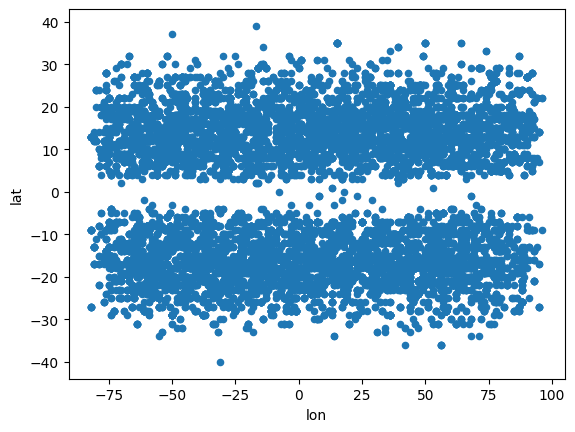

In [100]:
flares[["lat", "lon"]].plot(kind="scatter", x="lon", y="lat")  # all flares

Plot locations of ALL EVENTS

<Axes: xlabel='lon', ylabel='lat'>

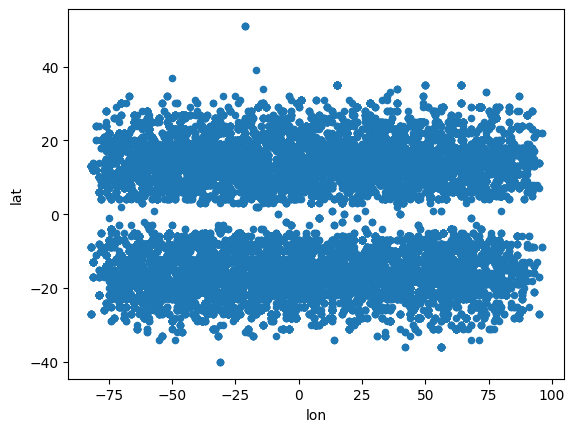

In [148]:
flares[["lat", "lon"]].plot(kind="scatter", x="lon", y="lat")  # all events

Histograms of flare lats lons

array([[<Axes: title={'center': 'lat'}>]], dtype=object)

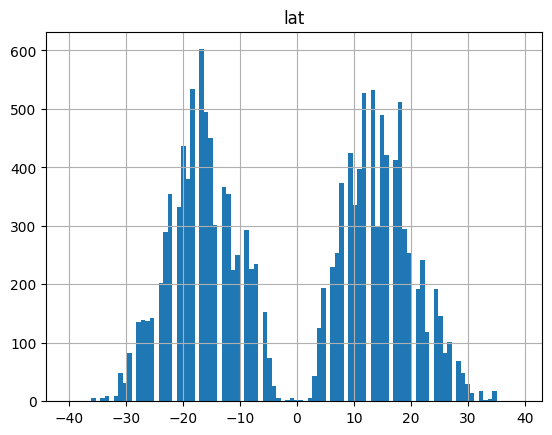

In [103]:
flares[["lat"]].hist(bins=100)

array([[<Axes: title={'center': 'lon'}>]], dtype=object)

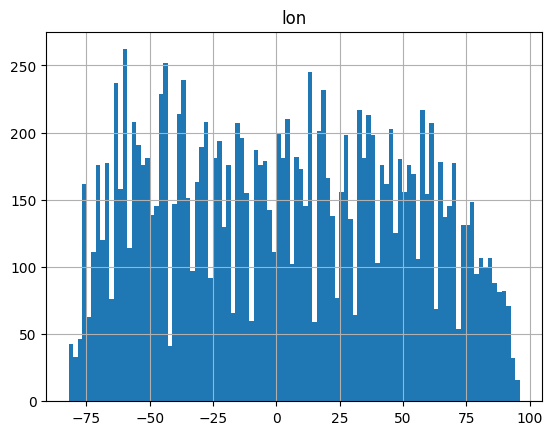

In [141]:
flares[["lon"]].hist(bins=100)

In [143]:
np.abs(flares[["lon"]]).mean()

lon    40.882827
dtype: float64

Quick and dirty fit bimodal normal

[-16.70937399   6.09435223 378.40714732  13.99135322   6.17535402
 377.26143234] 
 [ 0.70736189  0.71111009 38.0293868   0.71415002  0.71797381 37.78118185]


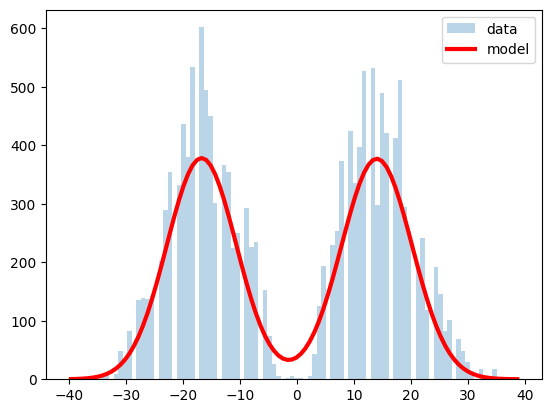

In [113]:
from pylab import *
from scipy.optimize import curve_fit
from sklearn import preprocessing

# min_max_scaler = preprocessing.MinMaxScaler()


# data=concatenate((normal(1,.2,5000),normal(2,.2,2500)))
data = flares["lat"].values
y, x, _ = hist(data, 100, alpha=0.3, label="data")

# y = preprocessing.minmax_scale(y, feature_range=(0, 1), axis=0, copy=True)

x = (x[1:] + x[:-1]) / 2  # for len(x)==len(y)


def gauss(x, mu, sigma, A):
    return A * exp(-((x - mu) ** 2) / 2 / sigma**2)


def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1) + gauss(x, mu2, sigma2, A2)


expected = (-20, 0.2, 250, 15, 0.2, 125)
params, cov = curve_fit(bimodal, x, y, expected)
sigma = sqrt(diag(cov))
plot(x, bimodal(x, *params), color="red", lw=3, label="model")
legend()
print(params, "\n", sigma)

If should be symmetric (expert question) then model all with one scaled normal

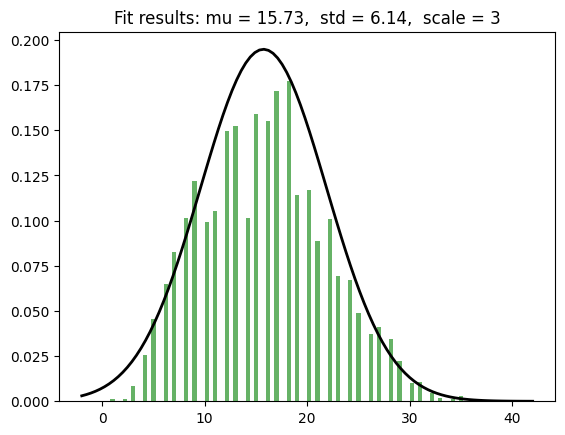

In [139]:
from pylab import *
from scipy.optimize import curve_fit
from sklearn import preprocessing
from scipy.stats import norm, lognorm

# min_max_scaler = preprocessing.MinMaxScaler()

# data=concatenate((normal(1,.2,5000),normal(2,.2,2500)))
data = abs(flares["lat"].values)
# y,x,_=hist(data,100,alpha=.3,label='data')
plt.hist(data, bins=100, density=True, alpha=0.6, color="g")
mu, std = norm.fit(data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std) * 3  # scaled
plt.plot(x, p, "k", linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f,  scale = 3" % (mu, std)
plt.title(title)

plt.show()

/opt/conda/envs/sdofm/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6556: RuntimeWarning: divide by zero encountered in log
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


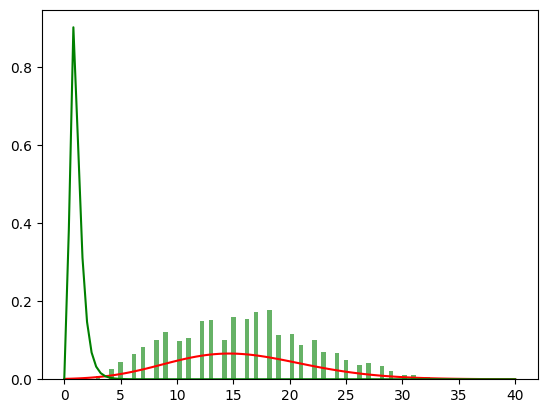

In [130]:
data = abs(flares["lat"].values)
plt.hist(data, bins=100, density=True, alpha=0.6, color="g")
param = lognorm.fit(data)

x = np.linspace(np.min(data), np.max(data), 100)
pdf_fitted = lognorm.pdf(
    x, param[0], loc=param[1], scale=param[2]
)  # fitted distribution
pdf = lognorm.pdf(x, 0.5, loc=0, scale=1)  # original distribution
plt.plot(x, pdf_fitted, "r-", x, pdf, "g-")

plt.show()